In [1]:
#  INSTALACIÓN DE LIBRERÍAS

!pip install datasets transformers scikit-learn evaluate -q
print(" Librerías instaladas.")

# CARGA Y DIVISIÓN DEL DATASET (70/15/15)

from datasets import load_dataset, concatenate_datasets
import pandas as pd

print("\nCargando y preparando el dataset 'ag_news'...")
# Carga
ag_news_dataset = load_dataset("ag_news")
# Combina
full_dataset = concatenate_datasets([ag_news_dataset['train'], ag_news_dataset['test']])
# Mezcla
shuffled_dataset = full_dataset.shuffle(seed=42)
# Divide
train_test_split = shuffled_dataset.train_test_split(test_size=0.3)
train_dataset = train_test_split['train']
temp_dataset = train_test_split['test']
validation_test_split = temp_dataset.train_test_split(test_size=0.5)
validation_dataset = validation_test_split['train']
test_dataset = validation_test_split['test']
print(" Dataset listo y dividido en 70/15/15.")


# DEFINICIÓN DE MÉTRICAS Y VARIABLES GLOBALES
import numpy as np
import evaluate

# Mapeo de etiquetas (usado por todos los modelos)
labels = ag_news_dataset['train'].features['label'].names
id2label = {i: label for i, label in enumerate(labels)}
label2id = {label: i for i, label in enumerate(labels)}

# Función de métricas (usada por todos los Trainers)
f1_metric = evaluate.load("f1")
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return f1_metric.compute(predictions=predictions, references=labels, average="macro")

print("\n Funciones y variables globales listas.")
print("\n--- ¡Entorno preparado! Puedes proceder a entrenar tu siguiente modelo. ---")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.9 MB/s eta 0:00:00
 Librerías instaladas.

Cargando y preparando el dataset 'ag_news'...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

 Dataset listo y dividido en 70/15/15.



 Funciones y variables globales listas.

--- ¡Entorno preparado! Puedes proceder a entrenar tu siguiente modelo. ---


## Preparación inicial y RoBERTa


In [ ]:
# Instalación de librerías
!pip install datasets transformers scikit-learn evaluate -q
print(" Librerías instaladas.")

# CARGA Y DIVISIÓN DEL DATASET (70/15/15)

from datasets import load_dataset, concatenate_datasets
import pandas as pd

print("\nCargando y preparando el dataset 'ag_news'...")
# Carga
ag_news_dataset = load_dataset("ag_news")
# Combina
full_dataset = concatenate_datasets([ag_news_dataset['train'], ag_news_dataset['test']])
# Mezcla
shuffled_dataset = full_dataset.shuffle(seed=42)
# Divide
train_test_split = shuffled_dataset.train_test_split(test_size=0.3)
train_dataset = train_test_split['train']
temp_dataset = train_test_split['test']
validation_test_split = temp_dataset.train_test_split(test_size=0.5)
validation_dataset = validation_test_split['train']
test_dataset = validation_test_split['test']
print("✅ Dataset listo y dividido en 70/15/15.")

# TOKENIZACIÓN PARA ROBERTA

from transformers import AutoTokenizer

model_checkpoint = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True)

print(f"\nTokenizando datasets para '{model_checkpoint}'...")
tokenized_train_dataset = train_dataset.map(tokenize_function, batched=True)
tokenized_validation_dataset = validation_dataset.map(tokenize_function, batched=True)
tokenized_test_dataset = test_dataset.map(tokenize_function, batched=True)
print(" Tokenización completada.")

# Configuración de entrenamiento
import numpy as np
import evaluate
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer, DataCollatorWithPadding

# Cargar modelo
labels = ag_news_dataset['train'].features['label'].names
id2label = {i: label for i, label in enumerate(labels)}
label2id = {label: i for i, label in enumerate(labels)}
model = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint, num_labels=4, id2label=id2label, label2id=label2id)

# Función de métricas
f1_metric = evaluate.load("f1")
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return f1_metric.compute(predictions=predictions, references=labels, average="macro")

# Data Collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

training_args = TrainingArguments(
    output_dir="./results/roberta",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    learning_rate=5e-5,
    num_train_epochs=2,
    fp16=True,
    optim="adamw_torch_fused",
    gradient_checkpointing=True,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    push_to_hub=False,
    report_to="none"
)


# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_validation_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)
print(f"\n Configuración de entrenamiento para '{model_checkpoint}' lista.")


# ENTRENAMIENTO Y EVALUACIÓN FINAL

print("\n--- Iniciando el entrenamiento de RoBERTa (con plantilla robusta) ---")
trainer.train()
print("\n Entrenamiento de RoBERTa finalizado.")

print("\n--- Realizando la evaluación final sobre el conjunto de prueba... ---")
final_evaluation_results = trainer.evaluate(eval_dataset=tokenized_test_dataset)
roberta_f1_score = final_evaluation_results['eval_f1']

print("\n--- ✨ Resultados Definitivos de RoBERTa ✨ ---")
print(f"El F1-Score (Macro) final en el Test Set es: {roberta_f1_score:.4f}")
print("\nMétricas completas:")
print(final_evaluation_results)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 7.1 MB/s eta 0:00:00
 Librerías instaladas.

Cargando y preparando el dataset 'ag_news'...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

✅ Dataset listo y dividido en 70/15/15.


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]


Tokenizando datasets para 'roberta-base'...


Map:   0%|          | 0/89320 [00:00<?, ? examples/s]

Map:   0%|          | 0/19140 [00:00<?, ? examples/s]

Map:   0%|          | 0/19140 [00:00<?, ? examples/s]

 Tokenización completada.


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


/tmp/ipython-input-161587055.py:83: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



 Configuración de entrenamiento para 'roberta-base' lista.

--- Iniciando el entrenamiento de RoBERTa (con plantilla robusta) ---


Epoch,Training Loss,Validation Loss,F1
1,0.429000,0.430535,0.894632
2,0.290100,0.340914,0.919415



 Entrenamiento de RoBERTa finalizado.

--- Realizando la evaluación final sobre el conjunto de prueba... ---



--- ✨ Resultados Definitivos de RoBERTa ✨ ---
El F1-Score (Macro) final en el Test Set es: 0.9204

Métricas completas:
{'eval_loss': 0.34051957726478577, 'eval_f1': 0.9204274620241008, 'eval_runtime': 37.4226, 'eval_samples_per_second': 511.456, 'eval_steps_per_second': 63.945, 'epoch': 2.0}


## DeBERTa

In [ ]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer, DataCollatorWithPadding

# MODELO Y TOKENIZACIÓN
model_checkpoint_deberta = "microsoft/deberta-base"
tokenizer_deberta = AutoTokenizer.from_pretrained(model_checkpoint_deberta)

def tokenize_function_deberta(examples):
    return tokenizer_deberta(examples["text"], truncation=True)

print("Tokenizando los datasets para DeBERTa...")
tokenized_train_deberta = train_dataset.map(tokenize_function_deberta, batched=True)
tokenized_validation_deberta = validation_dataset.map(tokenize_function_deberta, batched=True)
tokenized_test_deberta = test_dataset.map(tokenize_function_deberta, batched=True)
print(" Tokenización para DeBERTa completada.")

# CARGAR MODELO
model_deberta = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint_deberta, num_labels=4, id2label=id2label, label2id=label2id)
print(f"\n Modelo '{model_checkpoint_deberta}' cargado.")

# Entrenamiento
data_collator_deberta = DataCollatorWithPadding(tokenizer=tokenizer_deberta)

training_args_deberta = TrainingArguments(
    output_dir="./results/deberta",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=4,
    fp16=False,
    learning_rate=5e-5,
    num_train_epochs=2,
    optim="adamw_torch_fused",
    gradient_checkpointing=True,
    logging_strategy="epoch",
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    push_to_hub=False,
    report_to="none"
)

trainer_deberta = Trainer(
    model=model_deberta,
    args=training_args_deberta,
    train_dataset=tokenized_train_deberta,
    eval_dataset=tokenized_validation_deberta,
    tokenizer=tokenizer_deberta,
    data_collator=data_collator_deberta,
    compute_metrics=compute_metrics,
)

print("\n--- Iniciando el entrenamiento de DeBERTa (con plantilla robusta) ---")
trainer_deberta.train()
print("\n Entrenamiento de DeBERTa finalizado.")

# Evaluación final de DeBERTa
print("\n--- Realizando la evaluación final de DeBERTa... ---")
final_evaluation_deberta = trainer_deberta.evaluate(eval_dataset=tokenized_test_deberta)
deberta_f1_score = final_evaluation_deberta['eval_f1']

print("\n---  Resultados Definitivos de DeBERTa  ---")
print(f"El F1-Score (Macro) final en el Test Set es: {deberta_f1_score:.4f}")

Tokenizando los datasets para DeBERTa...


Map:   0%|          | 0/89320 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/19140 [00:00<?, ? examples/s]

Map:   0%|          | 0/19140 [00:00<?, ? examples/s]

 Tokenización para DeBERTa completada.


Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3730266937.py:44: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_deberta = Trainer(



 Modelo 'microsoft/deberta-base' cargado.


The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 2, 'bos_token_id': 1}.



--- Iniciando el entrenamiento de DeBERTa (con plantilla robusta) ---


Epoch,Training Loss,Validation Loss,F1
1,0.269400,0.230774,0.933691
2,0.149300,0.203529,0.941852



 Entrenamiento de DeBERTa finalizado.

--- Realizando la evaluación final de DeBERTa... ---



---  Resultados Definitivos de DeBERTa  ---
El F1-Score (Macro) final en el Test Set es: 0.9440


## ModernBERT

In [2]:
# TOKENIZACIÓN PARA MODERNBERT
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, DataCollatorWithPadding

# Definimos el checkpoint para ModernBERT.
model_checkpoint_modernbert = "answerdotai/ModernBERT-base"
tokenizer_modernbert = AutoTokenizer.from_pretrained(model_checkpoint_modernbert)

def tokenize_function_modernbert(examples):
    return tokenizer_modernbert(examples["text"], truncation=True)

print("Tokenizando los datasets para ModernBERT...")
tokenized_train_modernbert = train_dataset.map(tokenize_function_modernbert, batched=True)
tokenized_validation_modernbert = validation_dataset.map(tokenize_function_modernbert, batched=True)
tokenized_test_modernbert = test_dataset.map(tokenize_function_modernbert, batched=True)
print(" Tokenización para ModernBERT completada.")

# CARGAR EL MODELO MODERNBERT

model_modernbert = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint_modernbert, num_labels=4, id2label=id2label, label2id=label2id)
print(f"\n Modelo '{model_checkpoint_modernbert}' cargado.")

# Entrenamiento
data_collator_modernbert = DataCollatorWithPadding(tokenizer=tokenizer_modernbert)


training_args_modernbert = TrainingArguments(
    output_dir="./results/modernbert", # Único cambio
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    learning_rate=5e-5,
    num_train_epochs=2,
    fp16=True,
    optim="adamw_torch_fused",
    gradient_checkpointing=True,
    logging_strategy="epoch",
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    push_to_hub=False,
    report_to="none"
)

trainer_modernbert = Trainer(
    model=model_modernbert,
    args=training_args_modernbert,
    train_dataset=tokenized_train_modernbert,
    eval_dataset=tokenized_validation_modernbert,
    tokenizer=tokenizer_modernbert,
    data_collator=data_collator_modernbert,
    compute_metrics=compute_metrics,
)

print("\n--- Iniciando el entrenamiento de ModernBERT ---")
trainer_modernbert.train()
print("\n Entrenamiento de ModernBERT finalizado.")


# EVALUACIÓN FINAL DE MODERNBERT

print("\n--- Realizando la evaluación final de ModernBERT... ---")
final_evaluation_modernbert = trainer_modernbert.evaluate(eval_dataset=tokenized_test_modernbert)
modernbert_f1_score = final_evaluation_modernbert['eval_f1']

print("\n---  Resultados Definitivos de ModernBERT  ---")
print(f"El F1-Score (Macro) final en el Test Set es: {modernbert_f1_score:.4f}")

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

Tokenizando los datasets para ModernBERT...


Map:   0%|          | 0/89320 [00:00<?, ? examples/s]

Map:   0%|          | 0/19140 [00:00<?, ? examples/s]

Map:   0%|          | 0/19140 [00:00<?, ? examples/s]

 Tokenización para ModernBERT completada.


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/599M [00:00<?, ?B/s]

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



 Modelo 'answerdotai/ModernBERT-base' cargado.


/tmp/ipython-input-3520738245.py:45: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_modernbert = Trainer(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': None, 'bos_token_id': None}.



--- Iniciando el entrenamiento de ModernBERT ---


W1021 13:30:50.285000 531 torch/_inductor/utils.py:1436] [1/0_1] Not enough SMs to use max_autotune_gemm mode


Epoch,Training Loss,Validation Loss,F1
1,0.258700,0.207326,0.938440
2,0.130800,0.207079,0.947549



 Entrenamiento de ModernBERT finalizado.

--- Realizando la evaluación final de ModernBERT... ---



---  Resultados Definitivos de ModernBERT  ---
El F1-Score (Macro) final en el Test Set es: 0.9490


--- Resultados Finales para Comparación ---


,Model,F1-Score (Macro)
2,ModernBERT,0.9490
1,DeBERTa,0.9440
0,RoBERTa,0.9204


/tmp/ipython-input-198316249.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(



 Gráfico guardado exitosamente en: outputs/f1_score_comparison.png


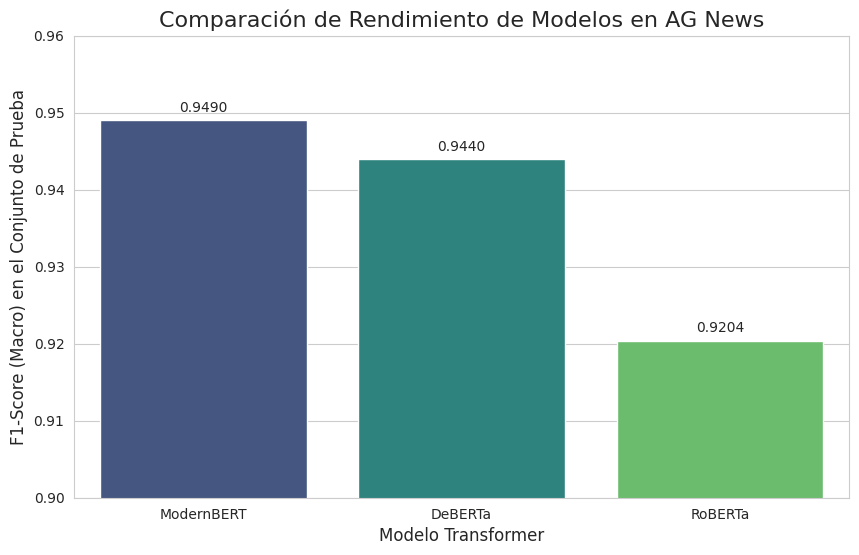

In [3]:
# instalar e importar librerías de visualización
!pip install matplotlib seaborn -q
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os


# RECOPILAR LOS RESULTADOS FINALES


# Reemplazar los valores de ejemplo de abajo con los F1-scores REALES que obtuviste.
roberta_f1_score = 0.9204       # Reemplaza con tu resultado
deberta_f1_score = 0.9440       # Reemplaza con tu resultado
modernbert_f1_score = 0.9490     # Reemplaza con tu resultado

# Crear un DataFrame de pandas con los resultados para facilitar el ploteo.
results_data = {
    'Model': ['RoBERTa', 'DeBERTa', 'ModernBERT'],
    'F1-Score (Macro)': [roberta_f1_score, deberta_f1_score, modernbert_f1_score]
}
df_results = pd.DataFrame(results_data)

# Ordenar los resultados para que el gráfico se vea mejor
df_results = df_results.sort_values(by='F1-Score (Macro)', ascending=False)

print("--- Resultados Finales para Comparación ---")
display(df_results)

# CREAR Y GUARDAR EL GRÁFICO COMPARATIVO

# Configuración del estilo del gráfico
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

# Crear el gráfico de barras
barplot = sns.barplot(
    x='Model',
    y='F1-Score (Macro)',
    data=df_results,
    palette='viridis'
)

# Añadir etiquetas con los valores exactos sobre cada barra
for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.4f'),
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha = 'center', va = 'center',
                     xytext = (0, 9),
                     textcoords = 'offset points')

# Personalización del gráfico
plt.title('Comparación de Rendimiento de Modelos en AG News', fontsize=16)
plt.xlabel('Modelo Transformer', fontsize=12)
plt.ylabel('F1-Score (Macro) en el Conjunto de Prueba', fontsize=12)
plt.ylim(0.9, 0.96) #s

# Guardar el gráfico en la carpeta /outputs
# Creamos la carpeta 'outputs' si no existe
output_dir = 'outputs'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Guardamos la figura
output_path = os.path.join(output_dir, 'f1_score_comparison.png')
plt.savefig(output_path, dpi=300, bbox_inches='tight')

print(f"\n Gráfico guardado exitosamente en: {output_path}")

plt.show()